# Data preprocessing

This notebook is based on https://machinelearningmastery.com/how-to-improve-neural-network-stability-and-modeling-performance-with-data-scaling.

In [29]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import make_regression
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD

We create synthetic data from Gaussian distribution:

In [60]:
X, y = make_regression(n_samples=1000, n_features=20, noise=0.1, random_state=1)

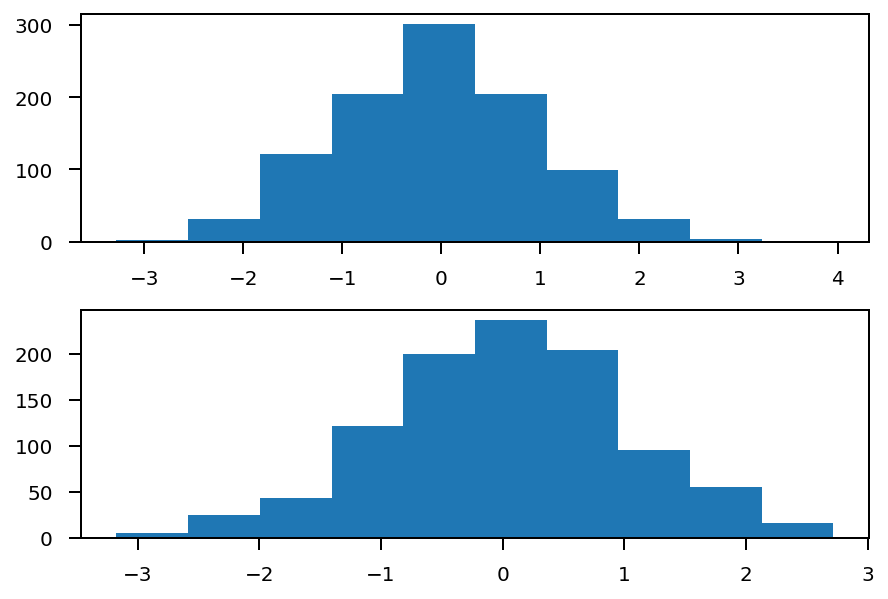

In [61]:
plt.subplot(211)
plt.hist(X[:, 0])
plt.subplot(212)
plt.hist(X[:, 1]);
plt.tight_layout(pad=0.1, h_pad=1)

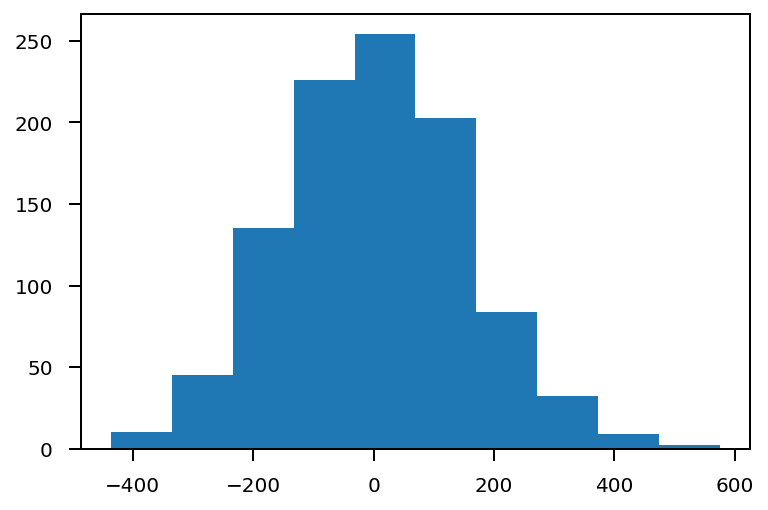

In [62]:
plt.hist(y);

In [9]:
%config InlineBackend.figure_format = "retina"

## Multilayer perceptron with unpreprocessed data

In [63]:
n_split = 500

train_x, test_x = X[:n_split], X[n_split:]
train_y, test_y = y[:n_split], y[n_split:]

Model is a multilayer perceptron with one hidden layer:

In [23]:
model = tf.keras.Sequential()

In [27]:
model.add(Dense(25, input_dim=20, activation="relu", kernel_initializer="he_uniform"))
model.add(Dense(1, activation="linear"))

In [30]:
model.compile(loss="mse", optimizer=SGD(lr=0.01, momentum=0.9))

Train the model:

In [38]:
history = model.fit(train_x, train_y, validation_data=(test_x, test_y), epochs=100, verbose=0)

In [32]:
train_mse = model.evaluate(train_x, train_y, verbose=0)
test_mse = model.evaluate(test_x, test_y, verbose=0)

In [33]:
print("Train MSE: {:.3f}, test MSE: {:.3f}".format(train_mse, test_mse))

Train MSE: nan, test MSE: nan


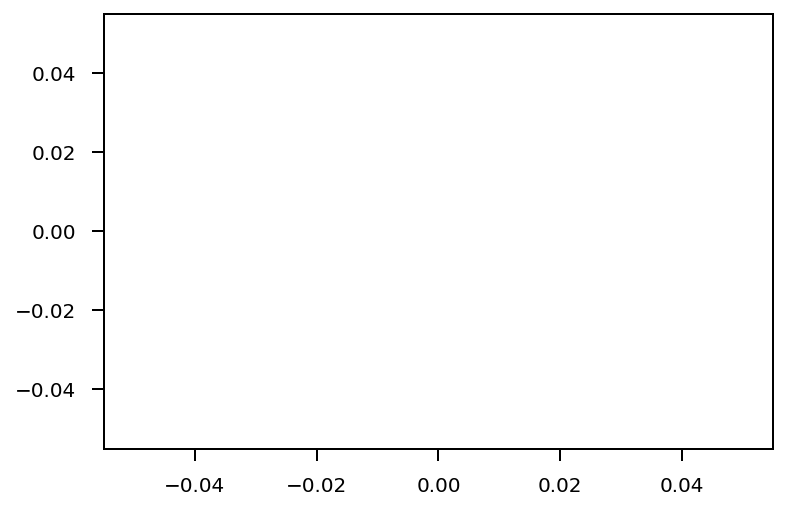

In [35]:
plt.figure()
plt.plot(history.history["loss"], label="Train")
plt.plot(history.history["val_loss"], label="Test");

What happened? The parameters of the model have exploded during the training:

In [36]:
model.trainable_variables[0]

<tf.Variable 'dense/kernel:0' shape=(20, 25) dtype=float32, numpy=
array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        

## Multilayer perceptron with scaled output variable

In [64]:
train_y = np.reshape(train_y, (-1, 1))
test_y = np.reshape(test_y, (-1, 1))

Now we can apply standardization to the data:

In [65]:
scaler = StandardScaler()
scaler.fit(train_y)
train_y = scaler.transform(train_y)
test_y = scaler.transform(test_y)

In [79]:
model = Sequential([
    Dense(25, input_dim=20, activation="relu", kernel_initializer="he_uniform"),
    Dense(1, activation="linear"),
])
model.compile(loss="mse", optimizer=SGD(lr=0.01, momentum=0.9))

In [80]:
history = model.fit(train_x, train_y, validation_data=(test_x, test_y), epochs=10000, verbose=0)

In [87]:
train_mse = model.evaluate(train_x, train_y, verbose=0)
test_mse = model.evaluate(test_x, test_y, verbose=0)

print("Train MSE: {:.3f}, test MSE: {:.3f}".format(train_mse, test_mse))

Train MSE: 0.000, test MSE: 0.000


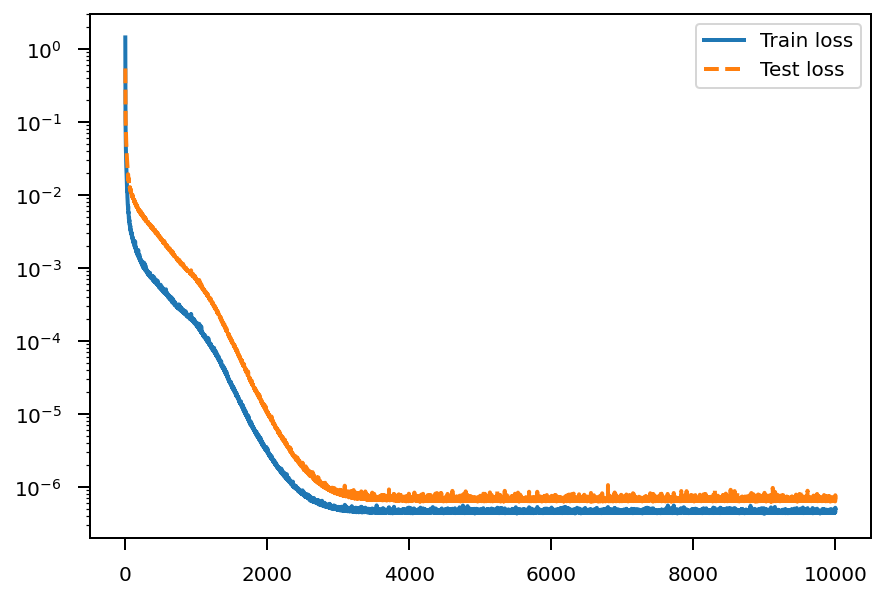

In [88]:
plt.figure()
plt.semilogy(history.history["loss"], "-", label="Train loss")
plt.semilogy(history.history["val_loss"], "--", label="Test loss")
plt.legend(loc="upper right")
plt.tight_layout(pad=0.1)

## Multilayer perceptron with scaled input variables

In [85]:
def get_dataset(input_scaler, output_scaler):
    X, y = make_regression(n_samples=1000, n_features=20, noise=0.1, random_state=1)
    n_split = 500

    train_x, test_x = X[:n_split], X[n_split:]
    train_y, test_y = y[:n_split], y[n_split:]
    
    if input_scaler is not None:
        input_scaler.fit(train_x)
        train_x = input_scaler.transform(train_x)
        test_x = input_scaler.transform(test_x)
    if output_scaler is not None:
        train_y = np.reshape(train_y, (-1, 1))
        test_y = np.reshape(test_y, (-1, 1))
        output_scaler.fit(train_y)
        train_y = output_scaler.transform(train_y)
        test_y = output_scaler.transform(test_y)
        
    return train_x, train_y, test_x, test_y

In [89]:
def evaluate_model(train_x, train_y, test_x, test_y):
    model = Sequential([
        Dense(25, input_dim=20, activation="relu", kernel_initializer="he_uniform"),
        Dense(1, activation="linear"),
    ])
    model.compile(loss="mse", optimizer=SGD(lr=0.01, momentum=0.9))
    history = model.fit(train_x, train_y, validation_data=(test_x, test_y), epochs=100, verbose=0)
    train_mse = model.evaluate(train_x, train_y, verbose=0)
    test_mse = model.evaluate(test_x, test_y, verbose=0)
    
    return history, train_mse, test_mse

We need to repeat model training multiple time to average over randomness:

In [83]:
def repeat_model_evaluation(input_scaler, output_scaler, n_repeat=30):
    train_x, train_y, test_x, test_y = get_dataset(input_scaler, output_scaler)
    results = []

    for i in range(n_repeat):
        __, __, test_mse = evaluate_model(train_x, train_y , test_x, test_y)
        print(f"Run {i:2d}, test_mse = {test_mse:.3f}")
        results.append(test_mse)
        
    return results

Now we run simulations with the following configurations of the transformations:

- no transformation for input variables, standardization for output variables;
- normalization for input variables, standardization for output variables;
- standardization for input variables, standardization for output variables.

In [90]:
results_1 = repeat_model_evaluation(None, StandardScaler())
results_2 = repeat_model_evaluation(MinMaxScaler(), StandardScaler())
results_3 = repeat_model_evaluation(StandardScaler(), StandardScaler())

Run  0, test_mse = 0.003
Run  1, test_mse = 0.001
Run  2, test_mse = 0.002
Run  3, test_mse = 0.002
Run  4, test_mse = 0.008
Run  5, test_mse = 0.003
Run  6, test_mse = 0.001
Run  7, test_mse = 0.007
Run  8, test_mse = 0.008
Run  9, test_mse = 0.004
Run 10, test_mse = 0.010
Run 11, test_mse = 0.002
Run 12, test_mse = 0.014
Run 13, test_mse = 0.013
Run 14, test_mse = 0.019
Run 15, test_mse = 0.006
Run 16, test_mse = 0.011
Run 17, test_mse = 0.005
Run 18, test_mse = 0.002
Run 19, test_mse = 0.010
Run 20, test_mse = 0.011
Run 21, test_mse = 0.004
Run 22, test_mse = 0.005
Run 23, test_mse = 0.013
Run 24, test_mse = 0.010
Run 25, test_mse = 0.005
Run 26, test_mse = 0.008
Run 27, test_mse = 0.009
Run 28, test_mse = 0.002
Run 29, test_mse = 0.013
Run  0, test_mse = 0.001
Run  1, test_mse = 0.001
Run  2, test_mse = 0.001
Run  3, test_mse = 0.000
Run  4, test_mse = 0.001
Run  5, test_mse = 0.000
Run  6, test_mse = 0.000
Run  7, test_mse = 0.000
Run  8, test_mse = 0.000
Run  9, test_mse = 0.000


In [91]:
print("Unscaled inputs, test mse {:.3f} \pm {:.3f}".format(np.mean(results_1), np.std(results_1)))
print("Normalized inputs, test mse {:.3f} \pm {:.3f}".format(np.mean(results_2), np.std(results_2)))
print("Standardized inputs, test mse {:.3f} \pm {:.3f}".format(np.mean(results_3), np.std(results_3)))

Unscaled inputs, test mse 0.007 \pm 0.005
Normalized inputs, test mse 0.000 \pm 0.000
Standardized inputs, test mse 0.006 \pm 0.003


Let's plot to see visually the differences:

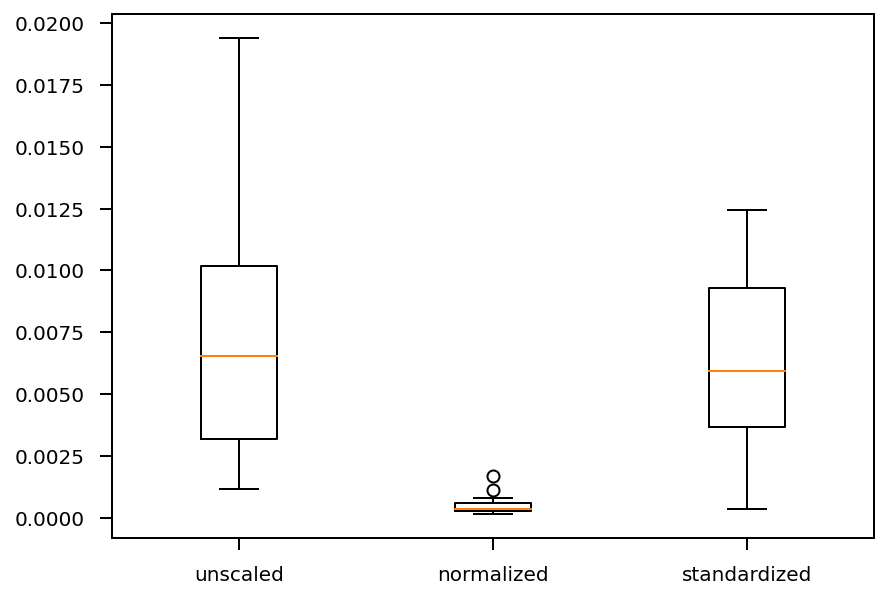

In [92]:
results = [results_1, results_2, results_3]
labels = ["unscaled", "normalized", "standardized"]
plt.figure()
plt.boxplot(results, labels=labels)
plt.tight_layout(pad=0.1)

In [95]:
np.mean(results_2), np.std(results_2)

(0.0004744418906435991, 0.00031749790990214823)